# 🔍 Exploratory Data Analysis (EDA) — Phase 1: Data Preparation

This notebook represents the **first step** of the forest fire prediction project.  
The goal of this phase is to **prepare and explore the data** before applying any machine learning algorithms.

---

## 🧩 Objectives

In this phase, we focus on:

- **Data Preprocessing:** Handling raw environmental datasets (soil and climate data) to ensure quality and consistency.  
- **Data Integration:** Combining multiple datasets from different sources into a unified structure.  
- **Feature Engineering (Initial):** Preparing relevant features and variables for later modeling steps.

---

## 🌍 Geographic Focus

Since the study targets **North African regions**, we specifically work with:

- **Algeria** and **Tunisia** shapefiles to obtain their polygon representations.  
- **Worldwide datasets** (e.g., soil, temperature, humidity, rainfall, wind speed) clipped to these regions of interest.

---

## ⚙️ Summary of Work in This Notebook
### Tp 1 
1. **Download** the necessary datasets.  
2. **Load** and inspect them using appropriate Python libraries (`pandas`, `geopandas`, `rasterio`, etc.).  
3. **Explore** and get familiar with GeoPandas for spatial data manipulation.  
4. **Clip** the global raster and vector data to the Algeria–Tunisia region.  
5. **Prepare** the resulting data for further exploration and modeling in upcoming phases.


In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
import os
from rasterio.enums import Resampling # ✅ Import Resampling
from shapely.geometry import Point
import numpy as np
from shapely.ops import unary_union


from scripts.explore_raster import show_raster , describe_raster
from scripts.clip_raster_with_shape import clip_raster_with_shape
from scripts.plots import plot_fire_map



# Concatenate for plotting
algeria_shp = gpd.read_file("../shapefiles/algeria/gadm41_DZA_0.shp")
tunisia_shp = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_0.shp")
alg_tun_shp = pd.concat([algeria_shp, tunisia_shp], ignore_index=True)

alg_tun_gpd = gpd.GeoDataFrame(geometry=[unary_union(alg_tun_shp.geometry)],
                                crs=alg_tun_shp.crs)






---

## ☁️ Climate Dataset — WorldClim (1950–2024)

In this notebook, we use **historical monthly climate data** from [WorldClim](https://worldclim.org/data/monthlywth.html),  
downscaled from **CRU-TS-4.09** and bias-corrected using **WorldClim 2.1**.  
We focus on the **2020–2024** period.

### 📦 Dataset Overview
- **Variables:**  
  - **Tprec** — average precimum temperature (°C)  
  - **Tmax** — average maximum temperature (°C)  
  - **Precipitation** — total monthly rainfall (mm)
- **Resolution:** 2.5, 5, or 10 arc-precutes (~21–340 km²)
- **Format:** GeoTIFF (.tif), one file per month (120 files per 10-year block)

### 🔬 Notes
- Each raster value represents the monthly average or total for that variable.
- In this project, we **load and clip** the 2020–2024 layers to **Algeria** and **Tunisia** using `rasterio` and `geopandas`.

---


### 🧭 Exploring the Climate Dataset

For exploration purposes, we used a **climate dataset with a 5-minute spatial resolution**, containing raster layers for **maximum temperature (Tmax)**, **minimum temperature (Tmin)**, and **precipitation (Tprec)**.

To better understand the dataset structure, we explored one raster example for each variable — specifically, the file corresponding to **January 2020**.

Each raster was analyzed using the `describe_raster()` function, which provides key information such as:

- **Dimensions** → width and height of the raster in pixels.  
- **CRS (Coordinate Reference System)** → defines how the geographic coordinates are projected on Earth.  
- **Resolution** → the real-world ground size represented by each pixel.  
- **Data type** → numerical format of pixel values (e.g., `float32`, `int16`).  
- **Bounds** → the geographic extent covered by the raster (min/max longitude and latitude).  
- **Contains NaN values** → indicates whether there are missing or masked regions (for example, areas outside the study zone).

Below, the first raster of **January 2020** is displayed as an example for each climate variable to visualize the data distribution.



🗺️ Exploring clipped raster (NumPy array)
Dimensions: 249 x 224
CRS: EPSG:4326
Resolution: 0.0833, 0.0833
Data type: float32
Bounds: (-8.75, 18.91666666666667, 12.0, 37.583333333333336)
Contains NaN values: True


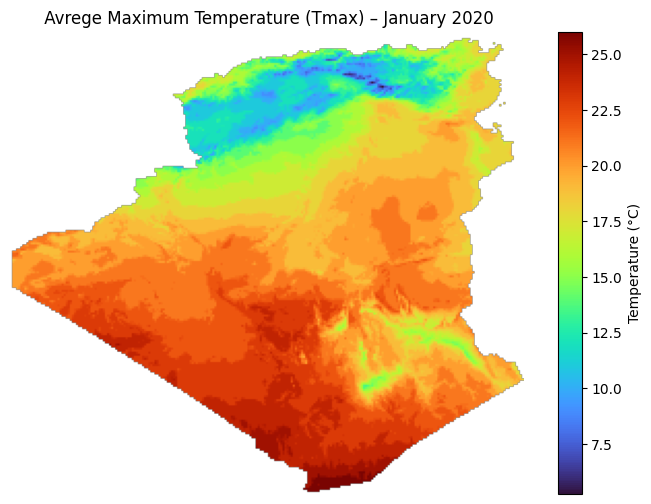

In [20]:
# === 🌡️ Exploring Maximum Temperature (Tmax) Data ===

# 1. Collect all Tmax raster file paths (sorted by date)
tmax_paths = sorted(glob.glob("../climate_dataset/5min/max/*.tif"))

# 2. Clip the first raster (e.g., January 2020) to Algeria–Tunisia boundary
tmax_image, tmax_transform, tmax_meta = clip_raster_with_shape(
    tmax_paths[0],
    alg_tun_gpd
)

# 3. Display raster metadata
describe_raster(tmax_image, tmax_meta, tmax_transform)

# 4. Visualize Tmax map
show_raster(
    tmax_image,
    cmap="turbo",               # good for temperature visualization
    title=" Avrege Maximum Temperature (Tmax) – January 2020",
    scale=None,
    colorbar_label="Temperature (°C)"
)



🗺️ Exploring clipped raster (NumPy array)
Dimensions: 249 x 224
CRS: EPSG:4326
Resolution: 0.0833, 0.0833
Data type: float32
Bounds: (-8.75, 18.91666666666667, 12.0, 37.583333333333336)
Contains NaN values: True


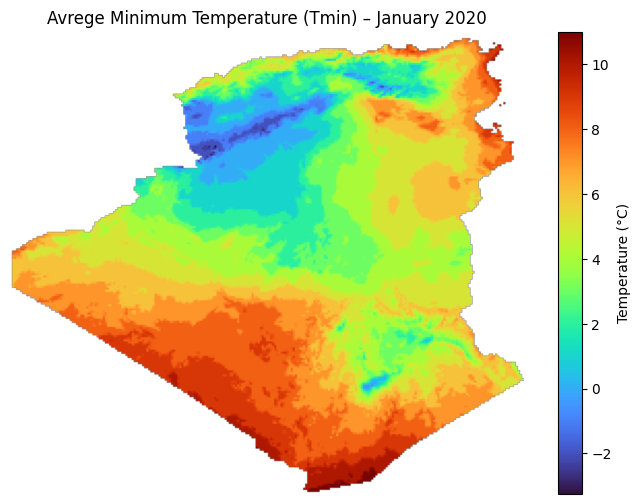

In [26]:
# === ❄️ Exploring Minimum Temperature (Tmin) Data ===

# 1. Collect all Tmin raster file paths (sorted by date)
tmin_paths = sorted(glob.glob("../climate_dataset/5min/min/*.tif"))

# 2. Clip the first raster (e.g., January 2020) to Algeria–Tunisia boundary
tmin_image, tmin_transform, tmin_meta = clip_raster_with_shape(
    tmin_paths[0],
    alg_tun_gpd
)

# 3. Display raster metadata
describe_raster(tmin_image, tmin_meta, tmin_transform)

# 4. Visualize Tmin map
show_raster(
    tmin_image,
    cmap="turbo",               # consistent with Tmax for comparison
    title="Avrege Minimum Temperature (Tmin) – January 2020",
    scale=None,
    colorbar_label="Temperature (°C)"
)



🗺️ Exploring clipped raster (NumPy array)
Dimensions: 249 x 224
CRS: EPSG:4326
Resolution: 0.0833, 0.0833
Data type: float32
Bounds: (-8.75, 18.91666666666667, 12.0, 37.583333333333336)
Contains NaN values: True


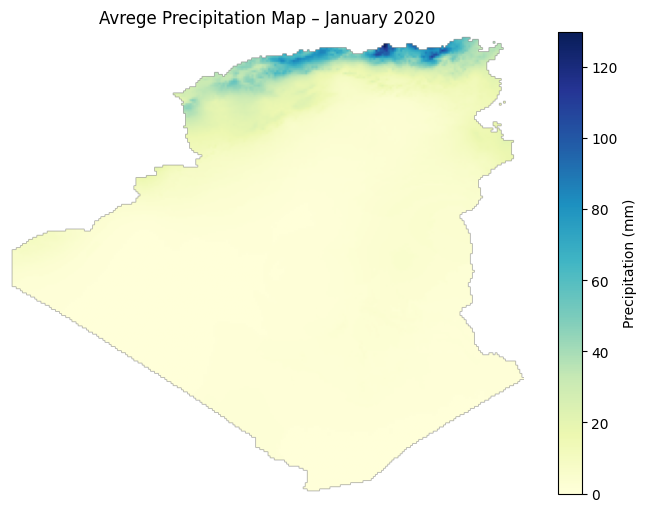

In [25]:
# === 🌧️ Exploring Precipitation (Tprec) Data ===

# 1. Collect all precipitation raster file paths (sorted by date)
tprec_paths = sorted(glob.glob("../climate_dataset/5min/prec/*.tif"))

# 2. Clip the first raster (e.g., January 2020) to Algeria–Tunisia boundary
tprec_image, tprec_transform, tprec_meta = clip_raster_with_shape(
    tprec_paths[0],
    alg_tun_gpd
)

# 3. Display raster metadata
describe_raster(tprec_image, tprec_meta, tprec_transform)

# 4. Visualize precipitation map
show_raster(
    tprec_image,
    cmap="YlGnBu",                 # blue-green scale suitable for precipitation
    title="Avrege Precipitation Map – January 2020",
    scale=None,
    colorbar_label="Precipitation (mm)"
)


---
# 🏔️ Elevation Dataset — GMTED2010

The **Global Multi-resolution Terrain Elevation Data 2010 (GMTED2010)** is a global digital elevation model developed by the **USGS** and **NGA**.  
It provides detailed topographic information at **7.5-, 15-, and 30-arc-second resolutions**, covering most of the Earth’s land surface between **84°N and 56°S** (and globally for some products).

The dataset offers several elevation products such as **mean, minimum, maximum, median, and standard deviation** of elevation values, derived from the best available global data sources.  
It significantly improves upon the older **GTOPO30** model, achieving a global vertical accuracy of around **6 meters RMSE**.


In this project, the GMTED2010 dataset is used to visualize and analyze the **elevation patterns** across Algeria and Tunisia.
You can learn more or download the dataset from the [USGS GMTED2010 official page](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-multi-resolution-terrain-elevation).



🗺️ Exploring clipped raster (NumPy array)
Dimensions: 4960 x 4465
CRS: EPSG:4326
Resolution: 0.0042, 0.0042
Data type: int16
Bounds: (-8.675138888889023, 18.958194444444377, 11.99152777777763, 37.56236111111103)
Contains NaN values: True


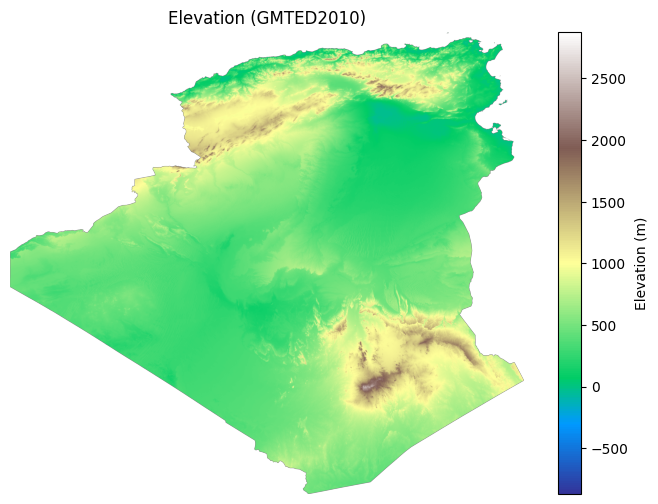

In [29]:
# === 🏔️ Exploring Elevation Data (GMTED2010) ===

# 1️⃣ Load the elevation raster file
elevation_file = "../elevation_dataset/be15_grd/w001001.adf"

# 2️⃣ Clip the raster to the Algeria–Tunisia boundary
elevation_image, elevation_transform, elevation_meta = clip_raster_with_shape(
    elevation_file,
    alg_tun_gpd
)

# 3️⃣ Display raster metadata
describe_raster(elevation_image, elevation_meta, elevation_transform)

# 4️⃣ Visualize the elevation map
show_raster(
    elevation_image,
    cmap="terrain",          # color scale suitable for elevation
    title="Elevation (GMTED2010)",
    scale=None,
    colorbar_label="Elevation (m)"
)


## Land Dataset

In [ ]:

# === 1. Load shapefile ===
landcover_dz = gpd.read_file("../land_dataset/algeria/dza_gc_adg.shp")

# === 2. Basic info ===
print("✅ Landcover Algérie chargé avec succès!")
print("\n📂 Nombre de lignes :", len(landcover_dz))
print("📋 Colonnes :", list(landcover_dz.columns))
print("\n🗺️ Type de géométrie :", landcover_dz.geom_type.unique())
print("🌍 Système de coordonnées :", landcover_dz.crs)

# === 3. Aperçu des données ===
print("\n🔹 Aperçu des 5 premières lignes :")
display(landcover_dz.head())



# === 5. Vérifier les valeurs uniques d’une colonne importante (ex: 'GRIDCODE') ===
if "GRIDCODE" in landcover_dz.columns:
    print("\n🌿 Valeurs uniques de GRIDCODE :")
    print(landcover_dz["GRIDCODE"].unique())

# === 6. Visualiser rapidement ===
landcover_dz.plot(column="GRIDCODE" if "GRIDCODE" in landcover_dz.columns else None,
                  legend=True,
                  figsize=(8, 6))


## 🔥 Fire Hotspots Dataset (NASA FIRMS)

For this exploration, we used the **Fire Information for Resource Management System (FIRMS)** dataset provided by **NASA** — available at [firms.modaps.eosdis.nasa.gov](https://firms.modaps.eosdis.nasa.gov/country/).

This dataset contains information on **active fire detections** captured by the MODIS and VIIRS satellite instruments.  
Each record corresponds to a detected fire pixel, with attributes describing its geographic location, brightness, time of acquisition, and confidence level.

**Key Columns:**
- **latitude, longitude** → Geographic coordinates of the detected fire.  
- **bright_ti4 / bright_ti5** → Brightness temperatures (in Kelvin) from different thermal bands.  
- **scan, track** → Dimensions of the satellite scan and track at the fire pixel.  
- **acq_date, acq_time** → Date and local time when the fire was detected.  
- **satellite** → Indicates the satellite source (e.g., Aqua, Terra, or Suomi NPP).  
- **instrument** → Sensor used for detection (MODIS or VIIRS).  
- **confidence** → Confidence level (%) of fire detection.  
- **frp** → Fire Radiative Power (MW), a measure of fire intensity.  
- **daynight** → Indicates if the detection occurred during **day** or **night**.  
- **type** → Type of fire detection (e.g., active fire, presumed fire, etc.).  

This dataset enables monitoring and analysis of fire activity across regions, useful for understanding temporal and spatial fire patterns.


✅ Fire data loaded: 90250 total rows


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,27.72818,9.87200,295.51,0.76,0.77,2024-01-01,3,N20,VIIRS,n,2,277.66,1.24,N,2
1,28.63288,9.77909,301.80,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.05,1.57,N,2
2,28.64012,9.77953,298.65,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.04,1.34,N,2
3,36.74886,6.25409,338.04,0.46,0.39,2024-01-01,141,N20,VIIRS,n,2,257.28,5.21,N,2
4,35.87978,4.44782,309.49,0.41,0.37,2024-01-01,141,N20,VIIRS,n,2,272.08,1.58,N,2


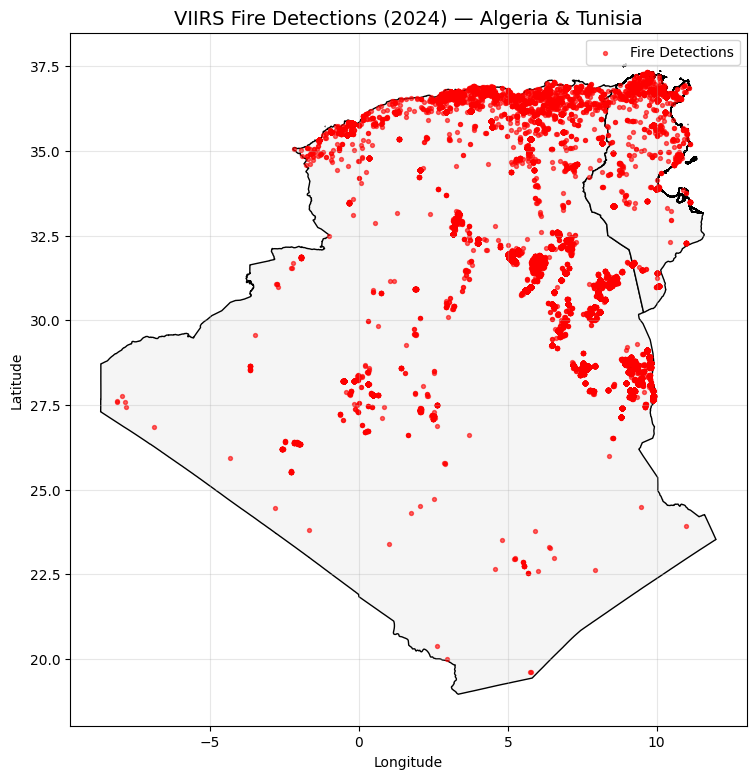

In [ ]:


#  Load the fire datasets for Algeria and Tunisia ---
fire_alg_path = "../fire_dataset/viirs-jpss1_2024_Algeria.csv"
fire_tun_path = "../fire_dataset/viirs-jpss1_2024_Tunisia.csv"

fire_alg = pd.read_csv(fire_alg_path)
fire_tun = pd.read_csv(fire_tun_path)

# Combine both datasets
fire_df = pd.concat([fire_alg, fire_tun], ignore_index=True)
print(f"✅ Fire data loaded: {len(fire_df)} total rows")
display(fire_df.head())


#  Convert fire detections to a GeoDataFrame ---
geometry = [Point(xy) for xy in zip(fire_df["longitude"], fire_df["latitude"])]
fire_gdf = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")  # WGS84



# Plot the combined fire detections ---
plot_fire_map(alg_tun_shp, fire_gdf, title="VIIRS Fire Detections (2024) — Algeria & Tunisia")


### Tunisia

✅ Fire data loaded: 2804 rows


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,31.64847,9.16945,315.79,0.53,0.50,2024-01-01,142,N20,VIIRS,n,2,279.09,2.20,N,2
1,31.49290,9.48947,302.32,0.56,0.51,2024-01-01,142,N20,VIIRS,n,2,276.10,1.23,N,0
2,31.49524,9.49053,301.88,0.56,0.51,2024-01-01,142,N20,VIIRS,n,2,276.12,0.77,N,0
3,33.36728,8.54768,302.58,0.45,0.47,2024-01-01,142,N20,VIIRS,n,2,277.15,0.80,N,2
4,31.64812,9.17107,320.80,0.46,0.39,2024-01-02,124,N20,VIIRS,n,2,278.37,2.44,N,2


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


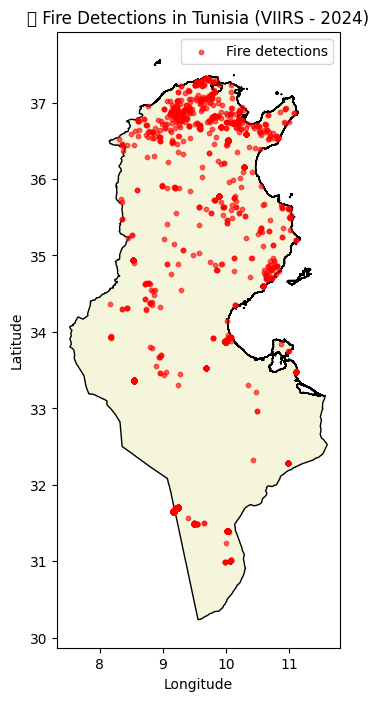

In [31]:


# === 1. Load fire dataset ===
fire_tn = pd.read_csv("../fire_dataset/viirs-jpss1_2024_Tunisia.csv")
print("✅ Fire data loaded:", len(fire_tn), "rows")
display(fire_tn.head())

# === 2. Convert to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(fire_tn["longitude"], fire_tn["latitude"])]
fire_tn_gdf = gpd.GeoDataFrame(fire_tn, geometry=geometry, crs="EPSG:4326")  # WGS84

# === 3. Load Tunisia shapefile ===
tunisia = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_0.shp")

# === 4. Plot fire points over Tunisia ===
fig, ax = plt.subplots(figsize=(8, 8))
tunisia.plot(ax=ax, color="beige", edgecolor="black")
fire_tn_gdf.plot(
    ax=ax,
    markersize=10,
    c="red",
    alpha=0.6,
    label="Fire detections"
)
plt.title("🔥 Fire Detections in Tunisia (VIIRS - 2024)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


# Soil Dataset

In [ ]:

# === Paths ===
base_dir = r"../soil_dataset"
raster_path = os.path.join(base_dir, "HWSD2_RASTER", "HWSD2.bil")
shapefile_path = os.path.join(base_dir, "country.shp")

# === Load shapefile ===
country = gpd.read_file(shapefile_path)

# === Open raster and read data (downsampled to save memory) ===
with rasterio.open(raster_path) as src:
    soil_data = src.read(1, out_shape=(
        int(src.height // 10),
        int(src.width // 10)
    ))
    transform = src.transform * src.transform.scale(
        (src.width / soil_data.shape[-1]),
        (src.height / soil_data.shape[-2])
    )
    nodata_value = src.nodata

# === Mask NoData values ===
if nodata_value is None:
    nodata_value = 0
soil_data = np.where(soil_data == nodata_value, np.nan, soil_data)

# === Plot map ===
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(
    soil_data,
    extent=[
        transform.c,
        transform.c + transform.a * soil_data.shape[1],
        transform.f + transform.e * soil_data.shape[0],
        transform.f
    ],cmap='terrain'
)
country.boundary.plot(ax=ax, color='black', linewidth=1)
plt.colorbar(ax.images[0], ax=ax, label='Soil Classes / Values')
plt.title("HWSD2 Soil Map", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## ShapeFiles

### Algeria

In [ ]:
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_0.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Frontière Algérie")
plt.show()


### Tunisia

In [ ]:
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_0.shp")

tunisia_poly = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_0.shp")
tunisia_poly.plot(edgecolor='red', facecolor='none')
plt.title("Frontière Tunisie")
plt.show()


In [ ]:
# Concatenate for plotting
alg_tun_shp = pd.concat([algeria_poly, tunisia_poly], ignore_index=True)


# === 2. Plot with border between countries ===
fig, ax = plt.subplots(figsize=(6, 6))
alg_tun_shp.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.2)
plt.title("Algeria–Tunisia Border", fontsize=12)
plt.axis("off")
plt.show()

## Worldwide Clip 

In [ ]:
# === 3. Create a single merged geometry for clipping ===
# (so that the raster clips to the combined shape)
merged_shape = gpd.GeoDataFrame(geometry=[unary_union(alg_tun_shp.geometry)],
                                crs=alg_tun_shp.crs)

# === 4. Clip raster to combined shape ===
clip_raster_to_shape(
    "../climate_dataset/5min/max/wc2.1_cruts4.09_5m_tmax_2020-01.tif",
    merged_shape
)

In [ ]:
# Algérie
clip_raster_to_shape("../elevation_dataset/be15_grd/w001001.adf",
                     merged_shape)




In [ ]:
# Algérie
clip_raster_to_shape("../soil_dataset/HWSD2_RASTER/HWSD2.bil",
                     merged_shape)

